# PCA - MNIST

En éste ejercicio vamos a aplicar PCA y K-means al digits dataset similar a MNIST, que incluye imágenes de dígitos de 8x8 píxeles. La idea es intentar recopilar información sobre la distribución de las imágenes, usando visualizaciones que permitan clarificar cómo interpretar los resultados obtenidos por PCA.

### Importamos librerías

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
import os
import gzip
import sys
import pandas as pd
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import normalize 
from sklearn.datasets import load_digits

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 17

In [2]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### Importamos el dataset

In [3]:
# Cargamos los datos de training
X, y = load_digits(return_X_y=True)
print('Formato del dataset: {}'.format(X.shape))

Formato del dataset: (1797, 64)


In [4]:
print('Formato de las etiquetas: {}'.format(y.shape))

Formato de las etiquetas: (1797,)


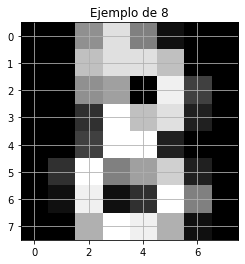

In [5]:
# Cargamos una muestra
plt.grid(True)
plt.title("Ejemplo de {}".format(y[8]))
plt.imshow(X[8, :].reshape((8, 8)), cmap='gray')

---

## Consignas

Siguiendo los ejemplos vistos en clase sobre los datasets de Human Activity Recognition y Fashion MNIST, realizar las siguientes consignas:

1. Aplicar PCA sobre el dataset para poder explicar el 90% de la varianza. ¿Cuántos componentes se requieren?
2. Graficar un scree plot (varianza contemplada en función del número de componentes considerados)
3. Visualizar gráficamente los primeros 5 componentes ¿Qué conclusiones se puede sacar de cada componente? [OPCIONAL].
4. Visualizar la imagen original vs. la reconstruida con los $m$ componentes del punto 1.
5. Graficar una matriz de correlación del dataset reducido.
6. Graficar los clusters de dígitos en 2 y 3 dimensiones usando los componentes obtenidos en PCA.
7. Aplicar K-means para clusterizar los dígitos ¿Cómo son los resultados?
8. Realizar un gráfico de inercia para obtener el número óptimo de clusters $k$.
9. Analizar visualmente los límites del cluster de algún dígito y "generar" artificialmente el dígito dándole valores a los primeros dos componentes de PCA.

-------------

## Exploración del dataset

In [6]:
# Exploramos un poco las features
df = pd.DataFrame(data=X)
df.describe()

0            1            2            3            4   \
count  1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean      0.0     0.303840     5.204786    11.835838    11.848080   
std       0.0     0.907192     4.754826     4.248842     4.287388   
min       0.0     0.000000     0.000000     0.000000     0.000000   
25%       0.0     0.000000     1.000000    10.000000    10.000000   
50%       0.0     0.000000     4.000000    13.000000    13.000000   
75%       0.0     0.000000     9.000000    15.000000    15.000000   
max       0.0     8.000000    16.000000    16.000000    16.000000   

                5            6            7            8            9   ...  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  ...   
mean      5.781859     1.362270     0.129661     0.005565     1.993879  ...   
std       5.666418     3.325775     1.037383     0.094222     3.196160  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       4.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%      11.000000     0.000000     0.000000     0.000000     3.000000  ...   
max      16.000000    16.000000    15.000000     2.000000    16.000000  ...   

                54           55           56           57           58  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000   
mean      3.725097     0.206455     0.000556     0.279354     5.557596   
std       4.919406     0.984401     0.023590     0.934302     5.103019   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     1.000000   
50%       1.000000     0.000000     0.000000     0.000000     4.000000   
75%       7.000000     0.000000     0.000000     0.000000    10.000000   
max      16.000000    13.000000     1.000000     9.000000    16.000000   

                59           60           61           62           63  
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  
mean     12.089037    11.809126     6.764051     2.067891     0.364496  
std       4.374694     4.933947     5.900623     4.090548     1.860122  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%      11.000000    10.000000     0.000000     0.000000     0.000000  
50%      13.000000    14.000000     6.000000     0.000000     0.000000  
75%      16.000000    16.000000    12.000000     2.000000     0.000000  
max      16.000000    16.000000    16.000000    16.000000    16.000000  

[8 rows x 64 columns]

In [7]:
df.isna().sum().sum()

0

In [26]:
# Cantidad única de clases
clases = np.unique(y)
clases

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [27]:
n_clases = clases.size

## Punto 1  
PCA sobre el dataset y reducción de dimensiones al 90% de la varianza

In [10]:
# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Se aplica PCA, de forma tal de dejar un 90% de la varianza aproximadamente. Dado que se aplica a la reconstrucción de imágenes, se itera con el gráfico scree plot para obtener el valor mencionado, con un número de componentes que permita reconstruir la matriz de la imagen

In [11]:
pca = PCA(n_components=32, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [12]:
# Cantidad de componentes necesarios
X_pca.shape[1]

32

## Punto 2
Gráfico scree plot

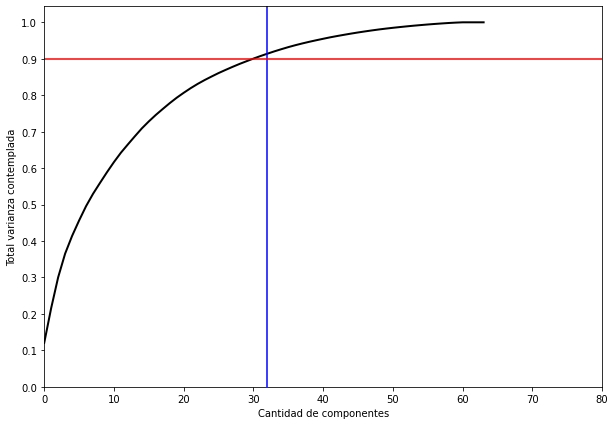

In [13]:
pca_2 = PCA(n_components=64, random_state=RANDOM_STATE).fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 80)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(32, c='b')
plt.axhline(0.9, c='r')
plt.show();

## Punto 4
Imagen real vs imagen reconstruida

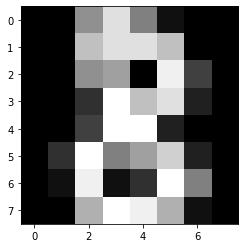

In [14]:
# Imagen original
plt.imshow(X[8, :].reshape((8, 8)), cmap='gray')

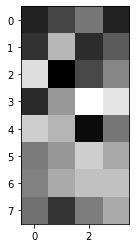

In [15]:
#Imagen reconstruida
plt.imshow(X_pca[8, :].reshape((8, 4)), cmap='gray')

## Punto 5
Se grafica la matriz de correlación utilizando las librerías de pandas

In [16]:
df2 = pd.DataFrame(data=X_pca)
corr_X_pca = df2.corr ()
corr_X_pca.style.background_gradient (cmap = 'coolwarm')

## Punto 6

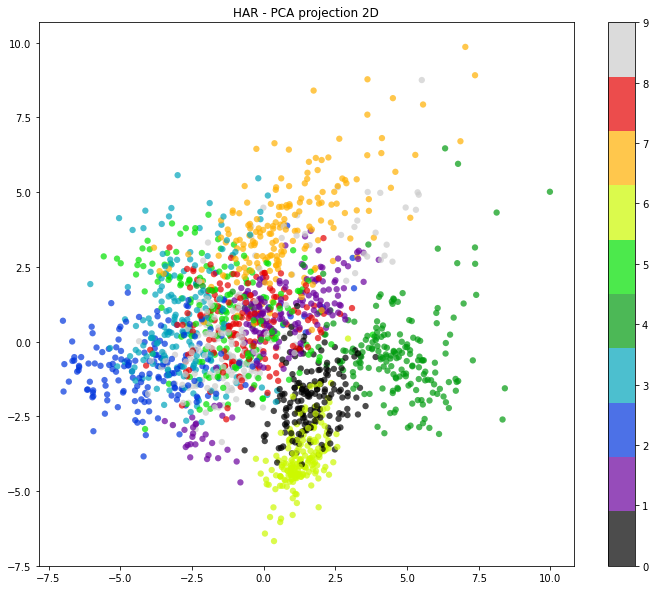

In [29]:
# Gráfico 2D tomando como referencia los primeros dos componentes
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('HAR - PCA projection 2D');

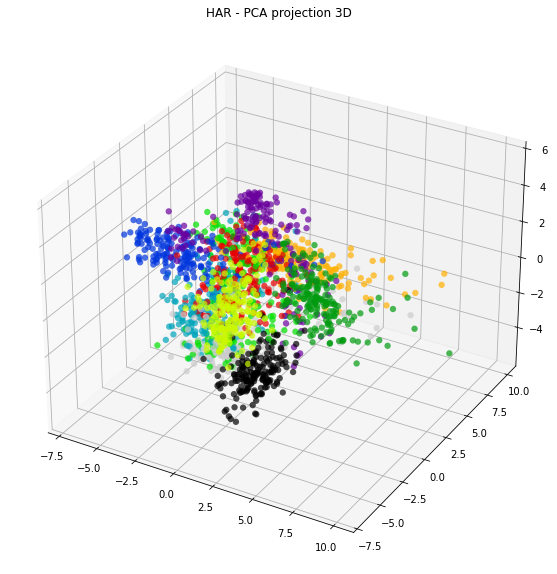

In [30]:
# Gráfico 3D tomando como referencia los primeros tres componentes
plt.figure(figsize=(12,10))
ax = plt.axes(projection ="3d")
ax.scatter3D(X_pca[:, 0], X_pca[:, 1],X_pca[:, 2], c=y, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.title('HAR - PCA projection 3D');

## Punto 7
Se emplea los métodos provistos por Skalearn para realizar la clusterización por k-means.

In [32]:
kmeans = KMeans(n_clusters=n_clases, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

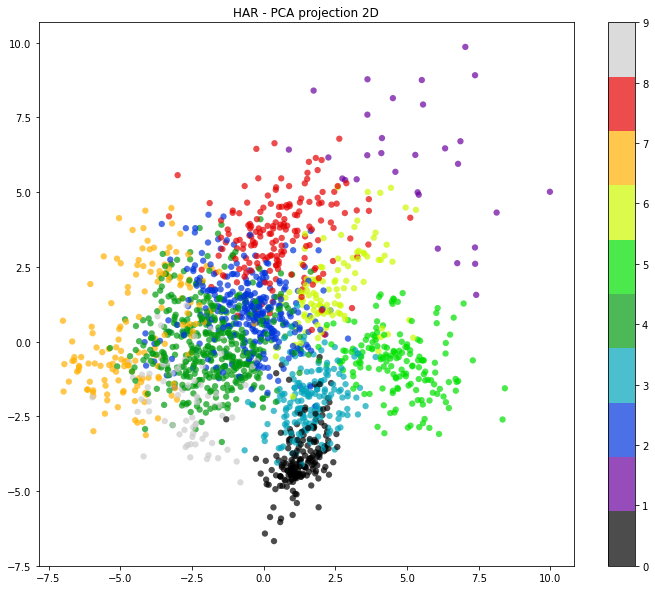

In [36]:
# Gráfico los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('HAR - PCA projection 2D');

Se muestra tabla con la distribución de los datos por cluster y clases

In [46]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = [0,1,2,3,4,5,6,7,8,9,'Todos']
tab.columns = ['cluster ' + str(i + 0) for i in range(10)] + ['Todos']
tab

cluster 0  cluster 1  cluster 2  cluster 3  cluster 4  cluster 5  \
0              0          0          0        177          0          1   
1              0          0         96          0          0          0   
2              0          0         31          0          6          0   
3              0          0         10          0        152          0   
4              0          9          4          0          0        157   
5              2          0         61          0         72          2   
6            175          0          4          1          0          0   
7              0         18          0          0          0          0   
8              3          0         98          0         47          0   
9              0          3          5          0        145          0   
Todos        180         30        309        178        422        160   

       cluster 6  cluster 7  cluster 8  cluster 9  Todos  
0              0          0          0          0    178  
1             58          0          1         27    182  
2              5         85          2         48    177  
3              0         13          7          1    183  
4              7          0          4          0    181  
5              2         41          2          0    182  
6              1          0          0          0    181  
7              3          8        150          0    179  
8             15          8          3          0    174  
9             19          0          8          0    180  
Todos        110        155        177         76   1797

## Ejercicio 8
El gráfico de inercia permite observar cuan óptimo ha sido la elección del número de clusters

In [47]:
# Inercia (suma de las distancias de los miembros de un cluster a su centroide)
inertia = []
for k in range(1, n_clases + 1):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

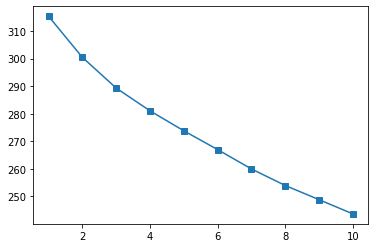

In [55]:
#Gráfico
plt.plot(range(1, 11), inertia, marker='s')